In [45]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

from sklearn.utils.multiclass import type_of_target

from sklearn import preprocessing

import re

In [2]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [3]:
df = pd.read_csv('E:\\Vakansy\\magnit\\data_regression_for_task.csv')
df.dropna(inplace=True)

In [4]:
df.isna().sum()

YEAR             0
MONTH            0
CONTRAGENT       0
ARTICLE_CODE     0
ARTICLE_NAME     0
ARTICLE_GROUP    0
SALES            0
STORE_SALES      0
dtype: int64

In [5]:
df#.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0
...,...,...,...,...,...,...,...,...
128348,2018,2,LEGENDS LTD,99753,DUTCHESS DE BOURGOGNE NR - 750ML,BEER,0.0,2.0
128349,2018,2,COASTAL BREWING COMPANY LLC,99813,DOMINION OAK BARREL STOUT 1/2K,KEGS,0.0,2.0
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0


In [6]:
df.columns

Index(['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME',
       'ARTICLE_GROUP', 'SALES', 'STORE_SALES'],
      dtype='object')

In [7]:
len(df['CONTRAGENT'].unique()), len(df['ARTICLE_CODE'].unique()), len(df['ARTICLE_NAME'].unique()), len(df['ARTICLE_GROUP'].unique())

(333, 23552, 23620, 8)

In [8]:
df['ARTICLE_GROUP'].unique()

array(['WINE', 'LIQUOR', 'BEER', 'STR_SUPPLIES', 'REF', 'NON-ALCOHOL',
       'KEGS', 'DUNNAGE'], dtype=object)

In [9]:
df['YEAR'].unique()

array([2017, 2018], dtype=int64)

In [10]:
df['SALES'].describe()

count    1.283300e+05
mean     6.564316e+03
std      2.892762e+04
min     -6.490000e+03
25%      0.000000e+00
50%      3.300000e+02
75%      3.250000e+03
max      1.616600e+06
Name: SALES, dtype: float64

In [11]:
df['STORE_SALES'].describe()

count    128330.000000
mean         22.681679
std         239.574553
min       -4996.000000
25%           0.000000
50%           1.000000
75%           4.000000
max       16271.750000
Name: STORE_SALES, dtype: float64

In [12]:
ohe = OneHotEncoder(categories = "auto",sparse = False)
df.dropna(inplace=True)
tp=ohe.fit_transform(df[['ARTICLE_GROUP']])
tp_col=pd.DataFrame(tp, columns=[df['ARTICLE_GROUP'].unique()])
df = pd.concat([df,tp_col],axis = 1)
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)","(BEER,)","(STR_SUPPLIES,)","(REF,)","(NON-ALCOHOL,)","(KEGS,)","(DUNNAGE,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
df.columns

Index([           'YEAR',           'MONTH',      'CONTRAGENT',
          'ARTICLE_CODE',    'ARTICLE_NAME',   'ARTICLE_GROUP',
                 'SALES',     'STORE_SALES',         ('WINE',),
             ('LIQUOR',),         ('BEER',), ('STR_SUPPLIES',),
                ('REF',),  ('NON-ALCOHOL',),         ('KEGS',),
            ('DUNNAGE',)],
      dtype='object')

In [14]:
df.isna().sum()
df.dropna(inplace=True)

In [15]:
xtrain, xtest, ytrain, ytest=train_test_split(df[[           'YEAR',           'MONTH',           'STORE_SALES',         ('WINE',),
             ('LIQUOR',),         ('BEER',), ('STR_SUPPLIES',),
                ('REF',),  ('NON-ALCOHOL',),         ('KEGS',),
            ('DUNNAGE',)]], df['SALES'], test_size=0.15)

e:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [17]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [18]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.9min finished


In [24]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Best: -659320398.665076 using {'max_depth': 2, 'n_estimators': 50}


In [28]:
xgbr = xgb.XGBRegressor(max_depth=2,n_estimators=50) 
xgbr.fit(xtrain, ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

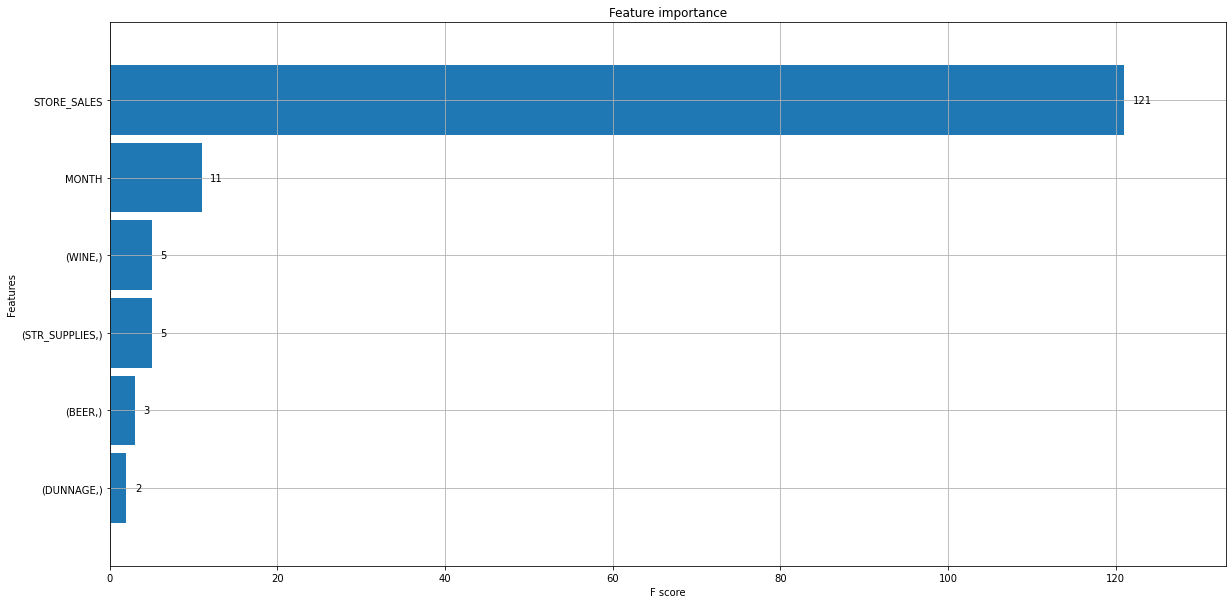

In [29]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgbr, height=0.9)

In [30]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)
#print("Training score: ", score)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [31]:
mse, mape, metr

(707198382.9451457, inf, 113.41241422282987)

# Модель со стандартизированными предикторами

In [ ]:
df1 = preprocessing.scale(df[[           'YEAR',           'MONTH',           'STORE_SALES',         ('WINE',),
             ('LIQUOR',),         ('BEER',), ('STR_SUPPLIES',),
                ('REF',),  ('NON-ALCOHOL',),         ('KEGS',),
            ('DUNNAGE',)]])

In [34]:
xtrain, xtest, ytrain, ytest=train_test_split(df1, df['SALES'], test_size=0.15)

In [35]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [36]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [37]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.9min finished


In [38]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Best: -636991492.983085 using {'max_depth': 2, 'n_estimators': 50}


In [39]:
xgbr = xgb.XGBRegressor(max_depth=2,n_estimators=50) 
xgbr.fit(xtrain, ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

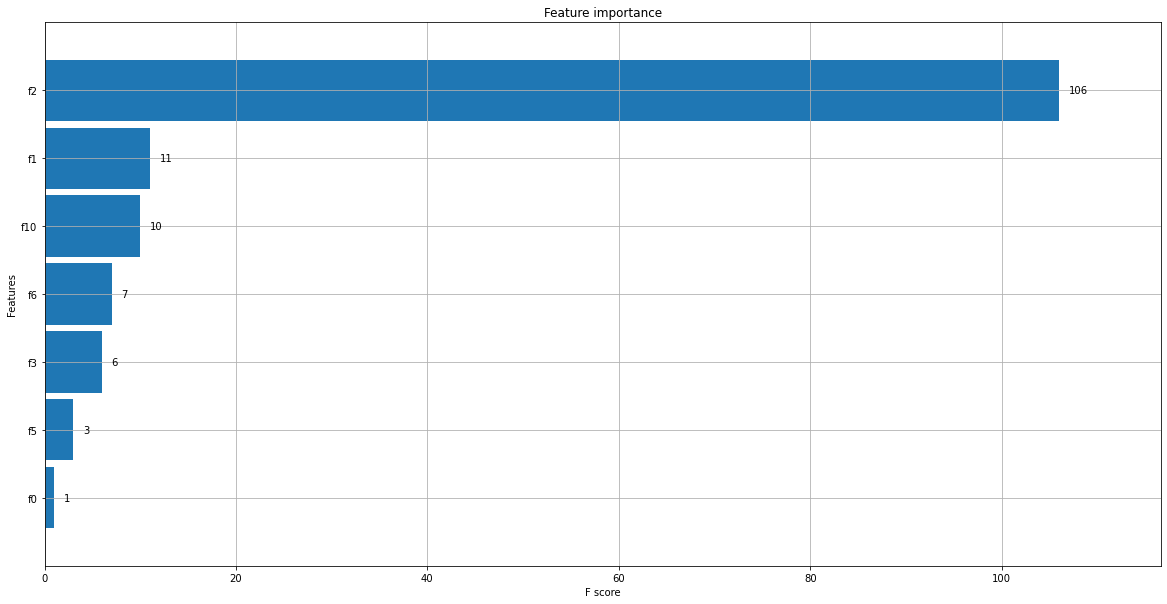

In [40]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgbr, height=0.9)

In [41]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)
#print("Training score: ", score)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [42]:
mse, mape, metr

(643717177.9927584, inf, 116.62618409703629)

# Добавим переменных

In [43]:
df#.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)","(BEER,)","(STR_SUPPLIES,)","(REF,)","(NON-ALCOHOL,)","(KEGS,)","(DUNNAGE,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128325,2018.0,2.0,LABATT USA OPERATING CO LLC,99333,MAGIC HAT #9 1/2K,KEGS,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128326,2018.0,2.0,YUENGLING BREWERY,99350,YUENGLING LAGER 1/4K,KEGS,0.0,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
128327,2018.0,2.0,INTERBALT PRODUCTS CORP,99368,BALTIKA #8 NR 20/CS - 16.9OZ,BEER,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128328,2018.0,2.0,HAMCO DC,9938,THERMAL REGISTER PAPER,STR_SUPPLIES,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
ohe = OneHotEncoder(categories = "auto",sparse = False)
df.dropna(inplace=True)
tp=ohe.fit_transform(df[['CONTRAGENT']])
tp_col=pd.DataFrame(tp, columns=[df['CONTRAGENT'].unique()])
df = pd.concat([df,tp_col],axis = 1)
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)",...,"(CHARLES JACQUIN ET CIE INC,)","(THE SANDY BOTTOM ENTERPRISES LLC,)","(SMITH-ANDERSON ENTERPRISES INC,)","(VINIFERA DISTRIBUTING OF MARYLAND INC,)","(PAMPA BEVERAGES LLC DBA TRANSNATIONAL SU,)","(DCD ENTERPRISES LLC,)","(BULLSHINE DISTILLERY LLC,)","(CASA CHIRICO LLC,)","(FREELANCE WINES LLC,)","(BLACK ANKLE VINEYARDS LLC,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
re.findall(r'\d{3}', 'GAMLA CAB - 750ML')

['750ML']

In [55]:
re.split(r'-', 'GAMLA CAB - 750ML')[-1]

' 750ML'

In [59]:
df['ARTICLE_NAME']

0                             GAMLA CAB - 750ML
1          SANTA MARGHERITA P/GRIG ALTO - 375ML
2         KNOB CREEK BOURBON 9YR - 100P - 375ML
3                 J W DANT BOURBON 100P - 1.75L
4                   RAMON CORDOVA RIOJA - 750ML
                          ...                  
128325                        MAGIC HAT #9 1/2K
128326                     YUENGLING LAGER 1/4K
128327             BALTIKA #8 NR 20/CS - 16.9OZ
128328                   THERMAL REGISTER PAPER
128329                    MAUDITE 6/4 NR - 12OZ
Name: ARTICLE_NAME, Length: 128330, dtype: object

In [75]:
#df['test']=df['ARTICLE_NAME'].apply(lambda x: re.split(r'-', x)[-1])
df.drop(columns='test', inplace=True)

In [84]:
df.isna().sum()
df.dropna(inplace=True)

In [85]:
x=df.columns
x

Index([                                       'YEAR',
                                             'MONTH',
                                        'CONTRAGENT',
                                      'ARTICLE_CODE',
                                      'ARTICLE_NAME',
                                     'ARTICLE_GROUP',
                                             'SALES',
                                       'STORE_SALES',
                                           ('WINE',),
                                         ('LIQUOR',),
       ...
                     ('CHARLES JACQUIN ET CIE INC',),
               ('THE SANDY BOTTOM ENTERPRISES LLC',),
                 ('SMITH-ANDERSON ENTERPRISES INC',),
          ('VINIFERA DISTRIBUTING OF MARYLAND INC',),
       ('PAMPA BEVERAGES LLC DBA TRANSNATIONAL SU',),
                            ('DCD ENTERPRISES LLC',),
                       ('BULLSHINE DISTILLERY LLC',),
                               ('CASA CHIRICO LLC',),
                 

In [133]:
x=list(x)
x1=[z for z in x if z not in ['CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME', 'ARTICLE_GROUP', 'SALES']]


In [134]:
xtrain, xtest, ytrain, ytest=train_test_split(df[x1], df['SALES'], test_size=0.15)

e:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [135]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [90]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [128]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   33.2s finished


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields CONTRAGENT, ARTICLE_GROUP

In [ ]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [136]:
xgbr = xgb.XGBRegressor(max_depth=2,n_estimators=50) 
xgbr.fit(xtrain, ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

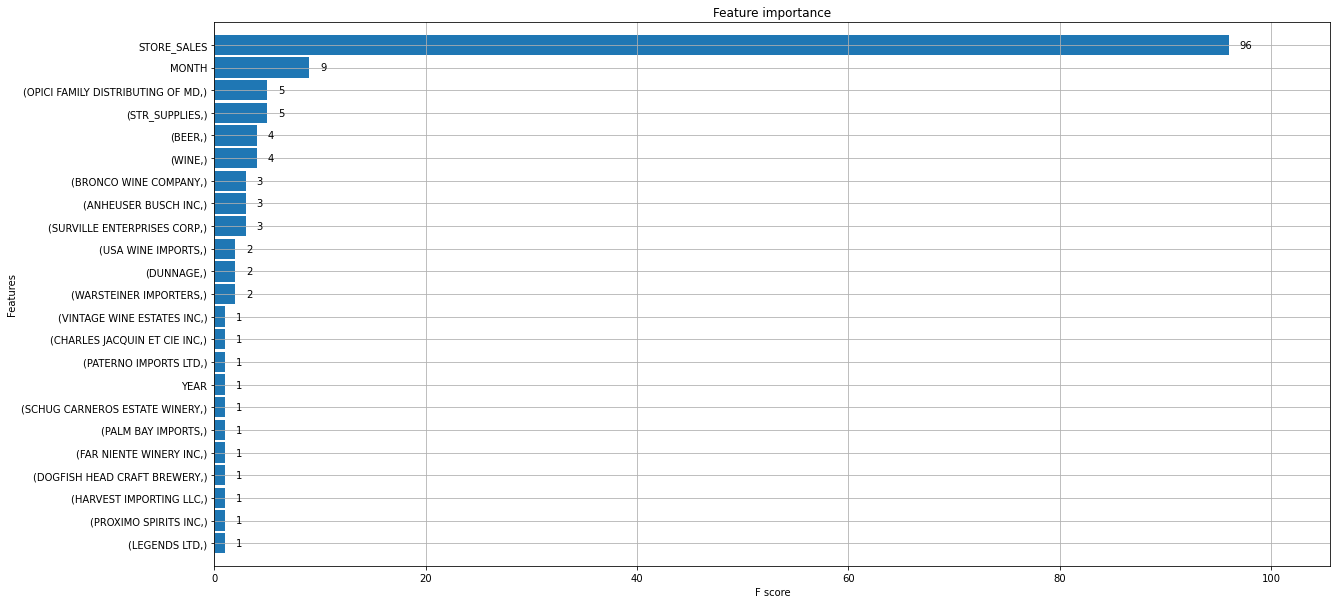

In [137]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgbr, height=0.9)

In [138]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)
#print("Training score: ", score)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [139]:
mse, mape, metr

(476317843.4629175, inf, 110.38530884023245)

# Попробуем ускорить это все

In [97]:
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,"(WINE,)","(LIQUOR,)",...,"(CHARLES JACQUIN ET CIE INC,)","(THE SANDY BOTTOM ENTERPRISES LLC,)","(SMITH-ANDERSON ENTERPRISES INC,)","(VINIFERA DISTRIBUTING OF MARYLAND INC,)","(PAMPA BEVERAGES LLC DBA TRANSNATIONAL SU,)","(DCD ENTERPRISES LLC,)","(BULLSHINE DISTILLERY LLC,)","(CASA CHIRICO LLC,)","(FREELANCE WINES LLC,)","(BLACK ANKLE VINEYARDS LLC,)"
0,2017.0,4.0,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017.0,4.0,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017.0,4.0,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017.0,4.0,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017.0,4.0,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
from catboost import Pool, CatBoostRegressor
import catboost as cb

cbb = cb.CatBoostRegressor(eval_metric="MAPE", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15,
                          cat_features=['CONTRAGENT', 'ARTICLE_GROUP'])
#clf = cbb()
#cbb.fit(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']],df['SALES'])
clf=cb.CatBoostRegressor(cat_features=['CONTRAGENT', 'ARTICLE_GROUP'])

In [140]:
cbb.fit(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']],df['SALES'])

0:	learn: 2360.1810398	total: 103ms	remaining: 51.6s
1:	learn: 2208.0510636	total: 201ms	remaining: 50.1s
2:	learn: 2066.4279858	total: 288ms	remaining: 47.7s
3:	learn: 1941.6936137	total: 378ms	remaining: 46.9s
4:	learn: 1847.3468545	total: 481ms	remaining: 47.7s
5:	learn: 1775.1816129	total: 535ms	remaining: 44.1s
6:	learn: 1702.7504600	total: 628ms	remaining: 44.2s
7:	learn: 1626.4387170	total: 693ms	remaining: 42.6s
8:	learn: 1560.7638620	total: 770ms	remaining: 42s
9:	learn: 1501.2692470	total: 831ms	remaining: 40.7s
10:	learn: 1406.3349585	total: 875ms	remaining: 38.9s
11:	learn: 1315.6078272	total: 951ms	remaining: 38.7s
12:	learn: 1237.4703532	total: 1.02s	remaining: 38.2s
13:	learn: 1180.4753271	total: 1.09s	remaining: 37.7s
14:	learn: 1129.1580014	total: 1.17s	remaining: 37.7s
15:	learn: 1089.1930673	total: 1.24s	remaining: 37.5s
16:	learn: 1050.7096106	total: 1.31s	remaining: 37.2s
17:	learn: 1012.9008670	total: 1.38s	remaining: 36.9s
18:	learn: 988.7304983	total: 1.44s	rema

158:	learn: 734.6531746	total: 9.64s	remaining: 20.7s
159:	learn: 732.4257251	total: 9.7s	remaining: 20.6s
160:	learn: 732.7003965	total: 9.76s	remaining: 20.6s
161:	learn: 732.4709230	total: 9.8s	remaining: 20.4s
162:	learn: 732.2824259	total: 9.82s	remaining: 20.3s
163:	learn: 730.4829261	total: 9.9s	remaining: 20.3s
164:	learn: 730.2869193	total: 9.95s	remaining: 20.2s
165:	learn: 730.6163721	total: 9.98s	remaining: 20.1s
166:	learn: 730.9534597	total: 10s	remaining: 20s
167:	learn: 729.8188959	total: 10.1s	remaining: 19.9s
168:	learn: 729.5698254	total: 10.1s	remaining: 19.9s
169:	learn: 729.5475843	total: 10.2s	remaining: 19.8s
170:	learn: 728.8834142	total: 10.3s	remaining: 19.8s
171:	learn: 728.6254668	total: 10.3s	remaining: 19.7s
172:	learn: 728.7990553	total: 10.4s	remaining: 19.6s
173:	learn: 728.7502167	total: 10.4s	remaining: 19.6s
174:	learn: 728.5282802	total: 10.5s	remaining: 19.4s
175:	learn: 726.7538979	total: 10.5s	remaining: 19.4s
176:	learn: 726.5279052	total: 10.6

312:	learn: 656.5515820	total: 19s	remaining: 11.3s
313:	learn: 656.5617255	total: 19.1s	remaining: 11.3s
314:	learn: 656.3670566	total: 19.1s	remaining: 11.2s
315:	learn: 654.6532738	total: 19.2s	remaining: 11.2s
316:	learn: 654.9612745	total: 19.3s	remaining: 11.1s
317:	learn: 655.0511295	total: 19.3s	remaining: 11.1s
318:	learn: 654.5139029	total: 19.4s	remaining: 11s
319:	learn: 654.7081550	total: 19.4s	remaining: 10.9s
320:	learn: 654.7684858	total: 19.5s	remaining: 10.9s
321:	learn: 654.9376028	total: 19.5s	remaining: 10.8s
322:	learn: 654.6853422	total: 19.6s	remaining: 10.7s
323:	learn: 654.8492006	total: 19.6s	remaining: 10.7s
324:	learn: 654.9890852	total: 19.6s	remaining: 10.6s
325:	learn: 654.7175536	total: 19.7s	remaining: 10.5s
326:	learn: 650.3609701	total: 19.8s	remaining: 10.5s
327:	learn: 650.2927097	total: 19.8s	remaining: 10.4s
328:	learn: 650.2609387	total: 19.9s	remaining: 10.3s
329:	learn: 650.0797107	total: 20s	remaining: 10.3s
330:	learn: 650.0225007	total: 20.

465:	learn: 627.0010481	total: 28s	remaining: 2.05s
466:	learn: 626.9710004	total: 28.1s	remaining: 1.98s
467:	learn: 626.9300080	total: 28.1s	remaining: 1.92s
468:	learn: 626.7167995	total: 28.2s	remaining: 1.86s
469:	learn: 626.6994749	total: 28.2s	remaining: 1.8s
470:	learn: 626.5458361	total: 28.3s	remaining: 1.74s
471:	learn: 626.5477952	total: 28.3s	remaining: 1.68s
472:	learn: 626.0414769	total: 28.4s	remaining: 1.62s
473:	learn: 626.0779185	total: 28.4s	remaining: 1.56s
474:	learn: 626.0950386	total: 28.5s	remaining: 1.5s
475:	learn: 626.1097937	total: 28.5s	remaining: 1.44s
476:	learn: 626.1265307	total: 28.5s	remaining: 1.38s
477:	learn: 626.0665227	total: 28.6s	remaining: 1.32s
478:	learn: 626.1438598	total: 28.7s	remaining: 1.26s
479:	learn: 625.9077912	total: 28.8s	remaining: 1.2s
480:	learn: 625.8276764	total: 28.8s	remaining: 1.14s
481:	learn: 625.9427751	total: 28.9s	remaining: 1.08s
482:	learn: 626.0408788	total: 29s	remaining: 1.02s
483:	learn: 625.6128292	total: 29s	

In [142]:
xtrain, xtest, ytrain, ytest=train_test_split(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']]
                                              , df['SALES'], test_size=0.15)

In [125]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
l2_leaf_reg=[x for x in range(9, 18)]
param_grid = dict(depth=max_depth, iterations=n_estimators, l2_leaf_reg=l2_leaf_reg)

In [126]:
kfold = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 34.3min finished


0:	learn: 29204.0684808	total: 77.3ms	remaining: 15.4s
1:	learn: 28937.4044232	total: 150ms	remaining: 14.9s
2:	learn: 28686.0568595	total: 235ms	remaining: 15.4s
3:	learn: 28447.3465781	total: 308ms	remaining: 15.1s
4:	learn: 28216.0088787	total: 380ms	remaining: 14.8s
5:	learn: 28002.6675105	total: 446ms	remaining: 14.4s
6:	learn: 27795.2188626	total: 498ms	remaining: 13.7s
7:	learn: 27595.0580797	total: 565ms	remaining: 13.6s
8:	learn: 27398.9402092	total: 639ms	remaining: 13.6s
9:	learn: 27215.6942715	total: 720ms	remaining: 13.7s
10:	learn: 27035.6837916	total: 790ms	remaining: 13.6s
11:	learn: 26868.9719234	total: 859ms	remaining: 13.5s
12:	learn: 26708.3084695	total: 925ms	remaining: 13.3s
13:	learn: 26550.6597876	total: 994ms	remaining: 13.2s
14:	learn: 26398.8447175	total: 1.07s	remaining: 13.3s
15:	learn: 26265.7097419	total: 1.14s	remaining: 13.1s
16:	learn: 26129.8620564	total: 1.19s	remaining: 12.8s
17:	learn: 26009.8929118	total: 1.26s	remaining: 12.8s
18:	learn: 25886.26

151:	learn: 22244.3459998	total: 8.45s	remaining: 2.67s
152:	learn: 22222.6700790	total: 8.49s	remaining: 2.61s
153:	learn: 22220.0370206	total: 8.56s	remaining: 2.56s
154:	learn: 22213.2027914	total: 8.61s	remaining: 2.5s
155:	learn: 22196.0452107	total: 8.64s	remaining: 2.44s
156:	learn: 22169.3861728	total: 8.69s	remaining: 2.38s
157:	learn: 22162.1002695	total: 8.73s	remaining: 2.32s
158:	learn: 22153.4040615	total: 8.79s	remaining: 2.27s
159:	learn: 22151.0455963	total: 8.81s	remaining: 2.2s
160:	learn: 22139.4789773	total: 8.86s	remaining: 2.15s
161:	learn: 22136.2054868	total: 8.91s	remaining: 2.09s
162:	learn: 22132.8288624	total: 8.96s	remaining: 2.03s
163:	learn: 22128.6086917	total: 9.01s	remaining: 1.98s
164:	learn: 22111.5062383	total: 9.05s	remaining: 1.92s
165:	learn: 22092.4323113	total: 9.12s	remaining: 1.87s
166:	learn: 22090.2211163	total: 9.16s	remaining: 1.81s
167:	learn: 22081.9168572	total: 9.21s	remaining: 1.75s
168:	learn: 22075.2025134	total: 9.26s	remaining: 

In [127]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Best: -535736094.131707 using {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 10}


In [129]:
cbb1 = cb.CatBoostRegressor(eval_metric="MAPE", depth=8, iterations= 200, l2_leaf_reg= 10, learning_rate= 0.15,
                          cat_features=['CONTRAGENT', 'ARTICLE_GROUP'])
cbb1.fit(df[['YEAR', 'MONTH', 'CONTRAGENT', 'ARTICLE_GROUP', 'STORE_SALES']],df['SALES'])

0:	learn: 2371.8888931	total: 82.9ms	remaining: 16.5s
1:	learn: 2227.8591782	total: 165ms	remaining: 16.3s
2:	learn: 2106.6049348	total: 241ms	remaining: 15.8s
3:	learn: 1990.4694573	total: 324ms	remaining: 15.9s
4:	learn: 1919.9785631	total: 403ms	remaining: 15.7s
5:	learn: 1831.5686971	total: 467ms	remaining: 15.1s
6:	learn: 1759.9912884	total: 545ms	remaining: 15s
7:	learn: 1623.8036039	total: 615ms	remaining: 14.8s
8:	learn: 1514.7921149	total: 676ms	remaining: 14.4s
9:	learn: 1414.9356778	total: 736ms	remaining: 14s
10:	learn: 1332.9374825	total: 790ms	remaining: 13.6s
11:	learn: 1269.8378388	total: 836ms	remaining: 13.1s
12:	learn: 1215.9617918	total: 882ms	remaining: 12.7s
13:	learn: 1159.2673766	total: 923ms	remaining: 12.3s
14:	learn: 1111.8843780	total: 993ms	remaining: 12.3s
15:	learn: 1071.1024977	total: 1.04s	remaining: 12s
16:	learn: 1040.1066994	total: 1.1s	remaining: 11.8s
17:	learn: 1012.2900970	total: 1.14s	remaining: 11.5s
18:	learn: 991.1478818	total: 1.19s	remainin

157:	learn: 757.5542481	total: 7.03s	remaining: 1.87s
158:	learn: 757.3868534	total: 7.05s	remaining: 1.82s
159:	learn: 756.6150636	total: 7.1s	remaining: 1.77s
160:	learn: 756.5243117	total: 7.12s	remaining: 1.73s
161:	learn: 756.7009640	total: 7.19s	remaining: 1.69s
162:	learn: 755.5480835	total: 7.25s	remaining: 1.65s
163:	learn: 755.2837763	total: 7.31s	remaining: 1.6s
164:	learn: 755.1115973	total: 7.33s	remaining: 1.55s
165:	learn: 754.6673105	total: 7.35s	remaining: 1.5s
166:	learn: 754.3480529	total: 7.37s	remaining: 1.46s
167:	learn: 754.1148741	total: 7.39s	remaining: 1.41s
168:	learn: 753.2106862	total: 7.45s	remaining: 1.37s
169:	learn: 752.1922795	total: 7.52s	remaining: 1.33s
170:	learn: 751.4392418	total: 7.56s	remaining: 1.28s
171:	learn: 751.5865227	total: 7.62s	remaining: 1.24s
172:	learn: 751.0557188	total: 7.65s	remaining: 1.19s
173:	learn: 750.4586784	total: 7.68s	remaining: 1.15s
174:	learn: 750.0410069	total: 7.75s	remaining: 1.11s
175:	learn: 749.8121947	total: 

In [145]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = cbb.predict(xtest[['YEAR', 'MONTH', 'CONTRAGENT', 
       'ARTICLE_GROUP', 'STORE_SALES']])
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [146]:
mse, metr, mape

(326112209.0315697, 78.8959946498212, inf)

In [131]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ypred = cbb1.predict(xtest[['YEAR', 'MONTH', 'CONTRAGENT', 
       'ARTICLE_GROUP', 'STORE_SALES']])
mse = mean_squared_error(ytest, ypred)
metr=metric(ytest, ypred)
mape=mean_absolute_percentage_error(ytest, ypred)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [132]:
mse, metr, mape

(345911914.9124873, 86.25782650272564, inf)